# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects using Open Images dataset.

In [8]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Select GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [9]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [10]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [11]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [12]:
# Open Images Class names
dataset_dir = "/data/xzz/OpenImage"
annotations_dir = os.path.join(dataset_dir, "challenge-2019-instance-segmentation-track-annotations")
class_names_open_df = pd.read_csv(os.path.join(annotations_dir, "challenge-2019-classes-description-segmentable.csv"))
#class_names_open_df = pd.read_csv("../open-images/challenge-2019-instance-segmentation-track-annotations/challenge-2019-classes-description-segmentable.csv")
class_names_open_dict = class_names_open_df.to_dict('record')
class_names_open = {x['Label']: x['Name'] for x in class_names_open_dict}
class_labels_open = {x['Name']: x['Label'] for x in class_names_open_dict}

#for i in range(81):
#    if class_names[i].capitalize() in class_labels_open:
#        print(i, class_names[i].capitalize(), class_labels_open[class_names[i].capitalize()])


## Run Object Detection

In [13]:
# Read csv files
truncated_df =  pd.read_csv(os.path.join(dataset_dir, "sample_truncated_submission.csv"))
empty_df =  pd.read_csv(os.path.join(dataset_dir, "sample_empty_submission.csv"))

# truncated_df = pd.read_csv("../open-images/sample_truncated_submission.csv")
# empty_df = pd.read_csv("../open-images/sample_empty_submission.csv")
truncated_df['PredictionString'][3]
truncated_dict = truncated_df.to_dict('record')
truncated_image_IDs = truncated_df.to_dict('list')['ImageID']
pred_str_list = truncated_dict[0]['PredictionString'].split(' ')
result = {'class_ids': [], 'scores': [], 'masks': []}
for i in range(0, len(pred_str_list), 3):
    result['class_ids'].append(class_names_open[pred_str_list[i]])
    result['scores'].append(pred_str_list[i+1])
    #result['masks'].append(decode_binary_mask(bytes(pred_str_list[i+2], encoding='utf-8'), (image.shape[0], image.shape[1])))
truncated_df


,ImageID,ImageWidth,ImageHeight,PredictionString
0,d390310a4ce1c08a,1080,1080,/m/01pns0 0.754811 eNqdlWmTmzgQhv+SDvCMPRWOmth...
1,851ead69b88d02ec,905,1599,/m/01g317 0.57979 eNplj0sOwyAMRK/kMfQUNUZ02U9E...
2,6bfa7127523df860,768,768,/m/0k4j 0.97572 eNoLzMsxCDDMSzMw9jP0B0EDQwM4aW...
3,1bdcf167aa8486c3,1600,1200,/m/01g317 0.87176 eNp9VMlygzAM/SUZZxmaXjrNuEuK...
4,56cffbbb9ef25c1f,-1,-1,NaN
5,3c98050656fcae7f,1066,1600,/m/01g317 0.996779 eNo1UmFvozAM/UsOEE5sU+82Xdu...
6,721568e01a744247,1118,1600,/m/018xm 0.637833 eNqLi8xJM7BOTjS08DT2NfI38Dfy...
7,7b018c5e3a20daba,1600,1066,/m/01g317 0.85117 eNqLiYrLN7DNCjDMMIj0N/Iz9Dcw...
8,414f07ba363e7e01,1600,1066,/m/01g317 0.97475 eNplU2mTmzAM/UsyEEhnOj1mdpol...
9,d446e853f7ad30d3,1600,900,/m/01g317 0.971963 eNpNj31zgjAMxr9SSlFxu9vtznO...


Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


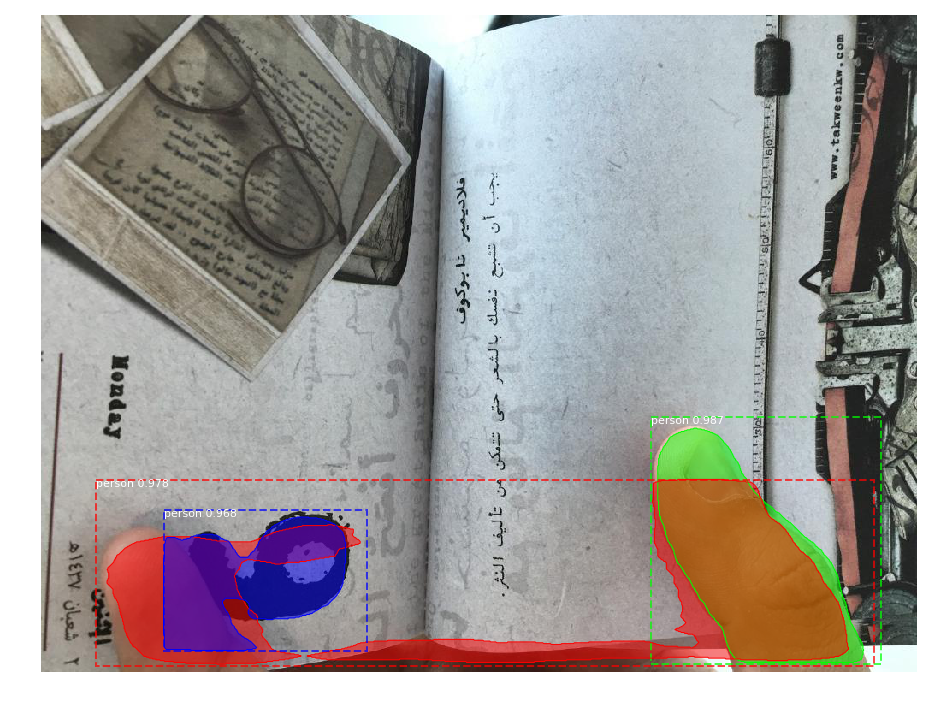

In [14]:
# Load a test image
IMAGE_DIR =  os.path.join(dataset_dir, "test_challenge_2018")
# IMAGE_DIR = "../open-images/test_challenge_2018"
file_name = '1bdcf167aa8486c3.jpg'
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
image_id = os.path.splitext(file_name)[0]

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Encode Segmentation Mask

In [15]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)
    
    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

def decode_binary_mask(base64_str: t.Text, img_size: tuple) -> np.ndarray:
    """Converts OID challenge encoding ascii text into a binary mask."""
    
    # base64 decoding and decompress --
    binary_str = base64.b64decode(base64_str)
    encoded_mask = zlib.decompress(binary_str)
    
    # RLE decode mask --
    mask_to_encode = coco_mask.decode([{'size': list(img_size), 'counts': encoded_mask}])
    
    # convert COCO API output to expected mask --
    mask_to_encode = np.ascontiguousarray(mask_to_encode)
    mask_to_encode = mask_to_encode.astype(np.bool)
    mask = np.squeeze(mask_to_encode)
    
    return mask

# Check correctness of decode_binary_mask
mask = results[0]['masks'][:,:,0]
de_mask = decode_binary_mask(encode_binary_mask(mask), (image.shape[0], image.shape[1]))
sum(sum(abs(mask.astype(np.uint8) - de_mask.astype(np.uint8))))

0

In [16]:
#print(results[0])
def generate_PredictionString(result, verbose=0):
    out = ""
    for i in range(len(result['class_ids'])):
        if len(out) > 0:
            out += ' '
        class_name = class_names[result['class_ids'][i]].capitalize()
        if class_name in class_labels_open:
            out += class_labels_open[class_name] + ' ' + str(result['scores'][i]) + ' ' + str(encode_binary_mask(result['masks'][:,:,i]), encoding='utf-8')
        elif verbose == 1:
            print('Class [' + class_name + '] not included in Open Images Challenge (Instance Segmentation Track)')
    return out

generate_PredictionString(results[0])


'/m/01g317 0.9867524 eNp9UckKAjEM/aUsLSKevAw4XXLVg8tBxIv4/zeTScvowNgHSfPystBej68bnPDygDvsd8MmcQ6KmOO4GUOKmTNXLiRUuHANKRRVFFIGBStXFKqaqz1CU1YyWJV6BPRYb2BV0hhxO3GWUdY9AApMxzLaxzZo9aoHlwsgNEpH29Biy3iO+khjpNt1TKOa/WWX3Lr6X+dlDdW52m7zph3OfINLyDM6F5PH9kT9M/z5zdunUI6H7fB+nvEDHMd5HA== /m/01g317 0.9782472 eNqllnubmjoQh7/SBNTdti4Ju922RyED4l0kCXhFwe//35m47h63xW2fHnnM751LQvDBzEzTkrGuG2/BKafIhlvg0rlcdz/a/Vbghq3QlW7Q7turddZOrxU6IcWkE9qvg0y6kkkGTBK/XFfEAIAhDejY0Vpn39mLDdTwafbejL13XVsfRKDxHsh+vcU+MClWTBUQy12KJZsWMJJViluWFDCRwyWu2DGHhZwssWD7HFI5X2LONtanLWlLK5uX5jCXO0tTm7e3MyaWjjZvmEMmqyUalliKMtQsykHLQYYZqw0YObR0NJDLcYYpKw2s5CTDBdsbWMtphnO2M7CRswxnbGtg+0IbAzu5yHDC1gb2Ms1wzFYGDpaGrDBQySzDAcsN1FekMoyZNhBhnmEFykCC+wzXMDaQ4iFD+ikMLLHKkEIGBAEfGHg8ZfgQG3iKFU5xHR5gVoBMFcJKAywVYq7BUQpDo8HVCgOtoU3aUxrucoXfST8VCp9TDd2Nwse5Bm+r0J9p4HuFCscaCigVppZWcFC4wKGGDRwVznCkYWtpan17G51YKqFSOMJEw+E2DTQcoVaYWF9lfWc6wslSbH1nijTUEInBLYhFhCces1ic5IlHbEB2/ZNWFE9ELWs+IK1kxZNGPfIhG4oD2SPSkuxxox74hI3Ejuwp6ZbsKRuTXV5p5rLrF57e6Z3ckX8qmn

In [17]:
def generate_csv_row(image, image_id, result, verbose=0):
    return pd.DataFrame({'ImageID': [image_id], 'ImageWidth': [image.shape[0]], 'ImageHeight': [image.shape[1]], 
                         'PredictionString': [generate_PredictionString(result, verbose=0)]})
generate_csv_row(image, image_id, results[0])

,ImageID,ImageWidth,ImageHeight,PredictionString
0,1bdcf167aa8486c3,768,1024,/m/01g317 0.9867524 eNp9UckKAjEM/aUsLSKevAw4XX...


In [18]:
# Get test results (pandas.DataFrame)
submission_list = []
file_names = next(os.walk(IMAGE_DIR))[2]
for i in range(len(file_names)):
    file_name = file_names[i]
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
    image_id = os.path.splitext(file_name)[0]
    print('Processing ' + file_name)
    
    # Run detection
    results = model.detect([image], verbose=0)
    
    # Visualize results
    r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #                        class_names, r['scores'])
    
    submission_list.append(generate_csv_row(image, image_id, r))

submission_df = pd.concat(submission_list, ignore_index=True)
submission_df

Processing 4266fb71b3fd8c1f.jpg
Processing c20302dd189b7336.jpg
Processing 03290a704565c6da.jpg
Processing 8641ccd7fdbd47ec.jpg
Processing d273e543c7da1e07.jpg
Processing 239c5e9c51be4532.jpg
Processing 7aecb7044328b01f.jpg
Processing d96e81148163cddb.jpg
Processing 0a73ced772057f3a.jpg
Processing 35c36597f1877f68.jpg
Processing bc56a0ec471ab9ff.jpg
Processing 9e26dd39a08b361d.jpg
Processing a65fdf0736214fa0.jpg
Processing 66b2ba36df074715.jpg
Processing 24ddab8b9bb14ca2.jpg
Processing 0707e4e195120a5f.jpg
Processing 7decd60eab5b6550.jpg
Processing 89dadc162d0292c0.jpg
Processing 762be3f2e3dd3c57.jpg
Processing 446d143eae643354.jpg
Processing 066bffc47c143942.jpg
Processing 4c952ec29db26bd5.jpg
Processing 55de62db5a8bb589.jpg
Processing a8809b4f5dfdb3a9.jpg
Processing 416c53f31f513600.jpg
Processing 013b23ca9b714927.jpg
Processing ed333c406c545b26.jpg
Processing 5dd1f924ebc47c14.jpg
Processing 2661753ad96aa6fd.jpg


KeyboardInterrupt: 

In [ ]:
# Save test results (.csv)
submission_df.to_csv('my_submission.csv', index=False)